In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import folium
import csv
import json
from ripple_helper import get_gateways_topology, get_gateways_df

# Processing transactions data

### Process transactions

In [2]:
data = pd.read_csv('txs-parsed-jan-2013-aug-2017/final_txs_2017.txt', delimiter='\n', header=None)

json_list = '['
for i in range(len(data)):
    json_text = data[0][i]
    json_list += json_text + ','
json_list = json_list[:-1]+']'

final_json = json.loads(json_list)
transactions = pd.DataFrame.from_dict(final_json)

### Process gateways

In [3]:
gateways_df = pd.read_csv('gateways.csv', sep=',').set_index('Unnamed: 0')
gateways_df['asn'] = gateways_df['asn'].apply(lambda x: x[2:-2])
gateways_accounts = gateways_df.index

In [4]:
cols = ['actualIssuerReceiver','issuerReceiver','issuerSender','receiver','sender']
for c in cols:
    mask = (transactions[c] != '--') & (transactions[c] != 'nan')
    l = list(transactions[mask][c].values)
    count = 0
    for acc in l:
        if(acc in gateways_accounts):
                count += 1
    print('Column: {} - Percentage of gateways: {}'.format(c,count/len(l)))

Column: actualIssuerReceiver - Percentage of gateways: 0.2413851587544084
Column: issuerReceiver - Percentage of gateways: 0.26485471367175434
Column: issuerSender - Percentage of gateways: 0.09547136892453775
Column: receiver - Percentage of gateways: 0.024353950745963724
Column: sender - Percentage of gateways: 8.854902771683505e-05


In [5]:
account_to_asn = gateways_df['asn'].to_dict()
account_to_asn['rKiCet8SdvWxPXnAgYarFUXMh1zCPz432Y'] = '38895'

In [6]:
def sanitize(x):
    if x == '16509 38895':
        return '38895'
    return x

In [7]:
gateways_df['lat-lon'] = list(zip(gateways_df.latitude, gateways_df.longitude))
ases = gateways_df[['asn','lat-lon']].copy()
ases['asn'] = ases['asn'].apply(lambda x: sanitize(x))
ases = ases.set_index('asn').to_dict()['lat-lon']

In [8]:
links = []
with open('gateway_links.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        links.append(tuple([row[0],row[1],1]))

In [9]:
gateways_graph = nx.Graph() 
gateways_graph.add_nodes_from(ases)
for n, p in ases.items():
    gateways_graph.node[n]['position'] = p
gateways_graph.add_weighted_edges_from(links)

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


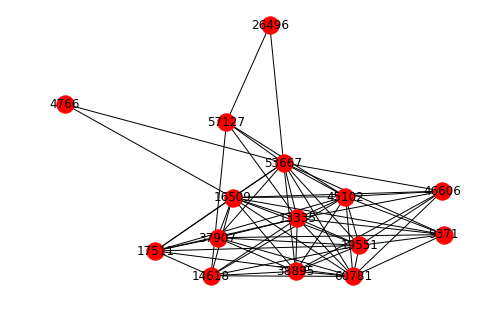

In [10]:
nx.draw(gateways_graph, with_labels=True)

In [11]:
nx.nodes(gateways_graph)

NodeView(('14618', '13335', '37907', '38895', '60781', '9371', '16509', '46606', '26496', '4766', '45102', '57127', '17511', '53667', '19551'))

In [12]:
def map_node_position(x):
    s = x[0]
    d = x[1]
    return tuple([positions[s],positions[d]])

In [13]:
def generate_map(graph):
    positions = nx.get_node_attributes(graph,'position')
    weights = nx.get_edge_attributes(graph,'weight')
    links = {}
    for key, value in weights.items():
        s = key[0]
        d = key[1]
        links[tuple([positions[s],positions[d]])] = value
    
    # Make an empty map
    m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)

    # I can add marker one by one on the map
    for node, pos in positions.items():
        folium.Marker(pos, popup=node).add_to(m)

    for edge, w in links.items():
        folium.PolyLine(locations=edge, weight=w).add_to(m)
    return m

In [14]:
generate_map(gateways_graph)

In [15]:
sender_cols = ['sender','issuerSender']
receiver_cols = ['receiver','issuerReceiver','actualIssuerReceiver']
for s in sender_cols:
    for r in receiver_cols:
        mask = transactions[s].isin(gateways_accounts) & transactions[r].isin(gateways_accounts)
        valid_transactions = transactions[mask][[s, r,'actualReceiverAmount']]
        valid_transactions[s] = valid_transactions[s].apply(lambda x: account_to_asn[x])
        valid_transactions[r] = valid_transactions[r].apply(lambda x: account_to_asn[x])
        for index, row in valid_transactions.iterrows():
            source = row[s]
            dest = row[r]
            amount = float(row['actualReceiverAmount'])

            if (source != dest and not math.isnan(amount)):
                try :
                    path = nx.shortest_path(gateways_graph,source, dest)
                    for i in range(len(path)-1):
                        s_p = path[i]
                        t_p = path[i+1]
                        gateways_graph[s_p][t_p]['weight'] += amount
                except:
                    print('No path between {} and {}'.format(source,dest))

In [16]:
for d in gateways_graph.degree(weight='weight'):
    print('AS: {} - Money: {}'.format(d[0],d[1]))

AS: 14618 - Money: 19763482.012461897
AS: 13335 - Money: 16205343.877910959
AS: 37907 - Money: 8.000298482993232
AS: 38895 - Money: 19598737.550145425
AS: 60781 - Money: 6573.246228113318
AS: 9371 - Money: 797.5592585532638
AS: 16509 - Money: 176427.63742745595
AS: 46606 - Money: 7
AS: 26496 - Money: 46.10200000000001
AS: 4766 - Money: 2
AS: 45102 - Money: 5443331.483016863
AS: 57127 - Money: 96.72006274000002
AS: 17511 - Money: 8.285690821305666
AS: 53667 - Money: 13.04720151651651
AS: 19551 - Money: 6742703.895961819


In [17]:
weight = nx.get_edge_attributes(gateways_graph,name='weight')
m = np.nanmax(list(weight.values()))
for u,v,d in gateways_graph.edges(data=True):
    d['weight'] = min(10,d['weight'])

In [18]:
generate_map(gateways_graph)

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


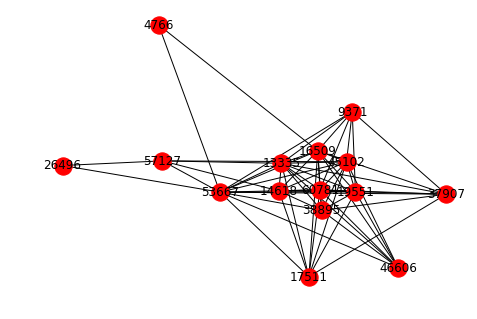

In [19]:
nx.draw(gateways_graph,with_labels=True)